In [92]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [64]:
ot_odr_filename = os.path.join(".", "OT_ODR.csv.bz2")
ot_odr_df = pd.read_csv(ot_odr_filename, compression="bz2", sep=";")

ot_odr_df["SYSTEM_N2"].replace("-", "NONE", inplace=True)

equipements_filename = os.path.join(".", 'EQUIPEMENTS.csv')
equipements_df = pd.read_csv(equipements_filename, sep=";")

/tmp/ipykernel_49788/3036638099.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ot_odr_df["SYSTEM_N2"].replace("-", "NONE", inplace=True)


In [65]:
#Séparation des données
train_df, test_df = train_test_split(ot_odr_df, test_size=0.2, random_state=42)

In [66]:
# Prédiction

def predict(bn, data, var_target, show_progress=False):
    """
    This function is used to predict the posterior probability of a target variable from observations
    using a bayesian network model.

    Inputs:
    - =bn=: the predictive model given as a =pyAgrum.BayesNet= object
    - =data=: the data containing the observations used to predict the target variable
    as a =pandas.DataFrame= object
    - =var_target=: the name of the target variable as a =str= object

    Returns:
    - a =DataFrame= containing the posterior probability distribution of the target
    variable given each observation in =data=.
    """
    # Initialize the inference engine
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i)
                           for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    for i in range(nb_data):
        # Set the evidence
        inf_bn.setEvidence(data_records[i])
        # Run inference
        inf_bn.makeInference()
        # Compute posterior probability of target variable
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        # Erase evidence
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob,
                                index=data.index,
                                columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

In [67]:
var_cat = ['ODR_LIBELLE', 'TYPE_TRAVAIL',
           'SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3', 
           'SIG_ORGANE', 'SIG_CONTEXTE', 'SIG_OBS', 'LIGNE']
train_df.info()
for var in var_cat:
    train_df[var] = train_df[var].astype('category')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405246 entries, 402189 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   OT_ID          405246 non-null  object 
 1   ODR_ID         405246 non-null  object 
 2   ODR_LIBELLE    405246 non-null  object 
 3   TYPE_TRAVAIL   405246 non-null  object 
 4   DUREE_TRAVAIL  405246 non-null  float64
 5   SYSTEM_N1      405246 non-null  object 
 6   SYSTEM_N2      405246 non-null  object 
 7   SYSTEM_N3      405246 non-null  object 
 8   EQU_ID         405246 non-null  object 
 9   DATE_OT        405246 non-null  object 
 10  KILOMETRAGE    405246 non-null  float64
 11  SIG_ORGANE     405246 non-null  object 
 12  SIG_CONTEXTE   405246 non-null  object 
 13  SIG_OBS        405246 non-null  object 
 14  LIGNE          405246 non-null  object 
dtypes: float64(2), object(13)
memory usage: 49.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 405246 entries, 402189 to

In [68]:
var_to_model = [
    'SYSTEM_N2',
    'SIG_ORGANE',
    'SIG_OBS'
]

var_bn = {}
for var in var_to_model:
    nb_values = len(train_df[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

for var in var_bn:
    for i, modalite in enumerate(train_df[var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

# Create the Bayesian Network
bn_etud = gum.BayesNet("modèle")

# Add the variables to the network
for var in var_bn.values():
    bn_etud.add(var)

# Define the structure by adding arcs
bn_etud.addArc("SYSTEM_N2", "SIG_OBS")
bn_etud.addArc("SYSTEM_N2", "SIG_ORGANE")

# Inspect the network structure
bn_etud


(pyAgrum.BayesNet<double>@0x60ca23a38b00) BN{nodes: 3, arcs: 2, domainSize: 307980, dim: 7829, mem: 61Ko 896o}

In [69]:
learner = gum.BNLearner(ot_odr_df[var_to_model])
learner.fitParameters(bn_etud)

(pyAgrum.BNLearner<double>@0x60ca247af6e0) Filename       : /tmp/tmpj208cxpu.csv
Size           : (506558,3)
Variables      : SYSTEM_N2[45], SIG_ORGANE[116], SIG_OBS[59]
Induced types  : True
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : MDL  (Not used for score-based algorithms)
Prior          : -

In [70]:
bn_ie = gum.LazyPropagation(bn_etud)

In [71]:
bn_ie.makeInference()

In [72]:
var_cat = ['ODR_LIBELLE', 'TYPE_TRAVAIL',
           'SYSTEM_N1', 'SYSTEM_N2', 'SYSTEM_N3', 
           'SIG_ORGANE', 'SIG_CONTEXTE', 'SIG_OBS', 'LIGNE']
for var in var_cat:
    test_df[var] = test_df[var].astype('category')

In [79]:
pred_prob = predict(bn_etud, data=test_df[["SIG_OBS", "SIG_ORGANE"]],
                    var_target="SYSTEM_N2", show_progress=True)

pred_var = pred_prob.idxmax(axis=1).rename("pred")

In [80]:
test_series = test_df["SYSTEM_N2"]
pred_series = pred_var

test_series = test_series.reindex(pred_series.index)

comparison_result = (test_series == pred_series).mean()
comparison_result

0.8156190777005685

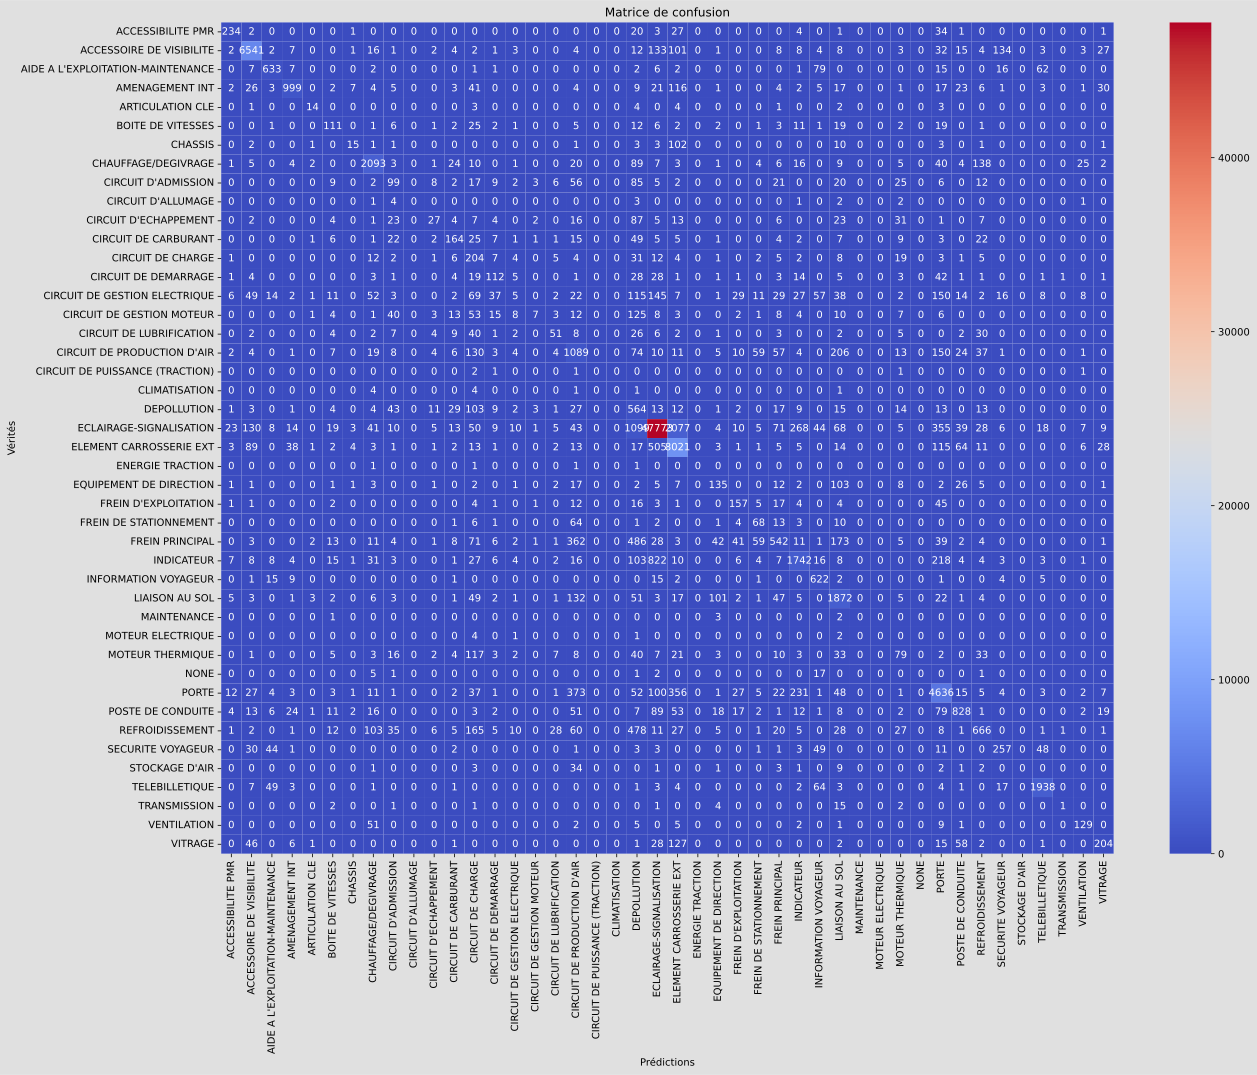

In [100]:
cm = confusion_matrix(test_df["SYSTEM_N2"], pred_var)

labels = test_df['SYSTEM_N2'].cat.categories.tolist()

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True,fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()